## Plots Needed:
1. Average reward over frames seen (by env and all)
2. Success rate over frames seen (by env and all)
3. Length of reasoning over steps

In [1]:
import wandb
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import pandas as pd

In [2]:
sns.set_theme(style="whitegrid", context="paper")
api = wandb.Api()

In [12]:
run_ids = {
    "Zero Distractors Reasoning 1": "wo542ivy",
    "Zero Distractors Reasoning 2": "9eq9ruv1",
    "Zero Distractors No Reasoning 1": "2h6u8ma8",
    "Zero Distractors No Reasoning 2": "u792g9lh",
    "Three Distractors Reasoning 1": "sn73rnpv",
    "Three Distractors Reasoning 2": "3j0398dw",
    "Three Distractors No Reasoning 1": "r5tb05d8",
    "Three Distractors No Reasoning 2": "snidzc0y",
    "Five Distractors Reasoning": "ksd1z4d1",
    "Five Distractors No Reasoning": "4cnv01b7"
}
no_reasoning_runs = {k: v for k, v in run_ids.items() if "No Reasoning" in k}
reasoning_runs = {k: v for k, v in run_ids.items() if "No Reasoning" not in k}

zero_distractor_reasoning_runs = {k: v for k, v in reasoning_runs.items() if "Zero Distractors" in k}
three_distractor_reasoning_runs = {k: v for k, v in reasoning_runs.items() if "Three Distractors" in k}
five_distractor_reasoning_runs = {k: v for k, v in reasoning_runs.items() if "Five Distractors" in k}

zero_distractor_no_reasoning_runs = {k: v for k, v in no_reasoning_runs.items() if "Zero Distractors" in k}
three_distractor_no_reasoning_runs = {k: v for k, v in no_reasoning_runs.items() if "Three Distractors" in k}
five_distractor_no_reasoning_runs = {k: v for k, v in no_reasoning_runs.items() if "Five Distractors" in k}

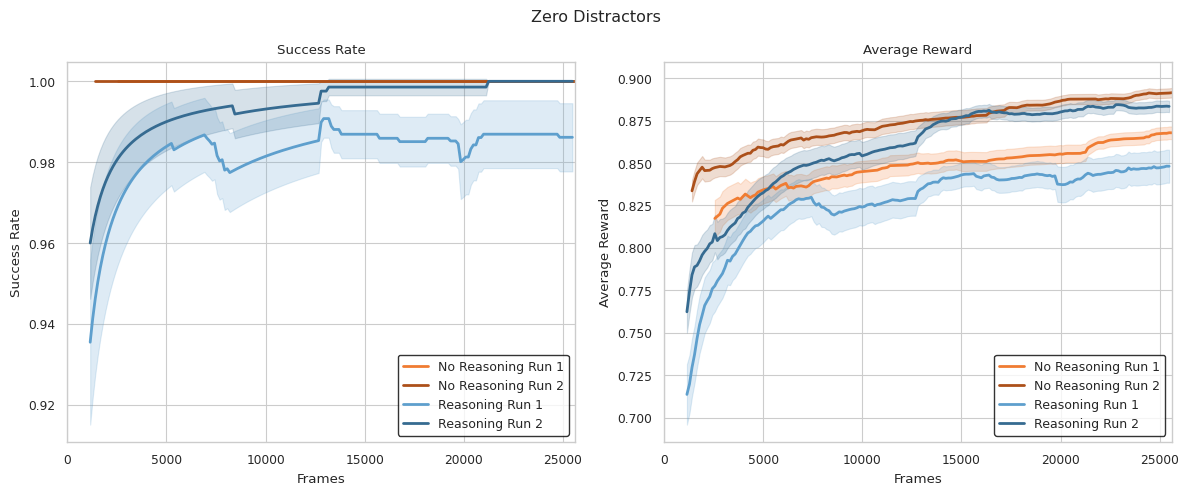

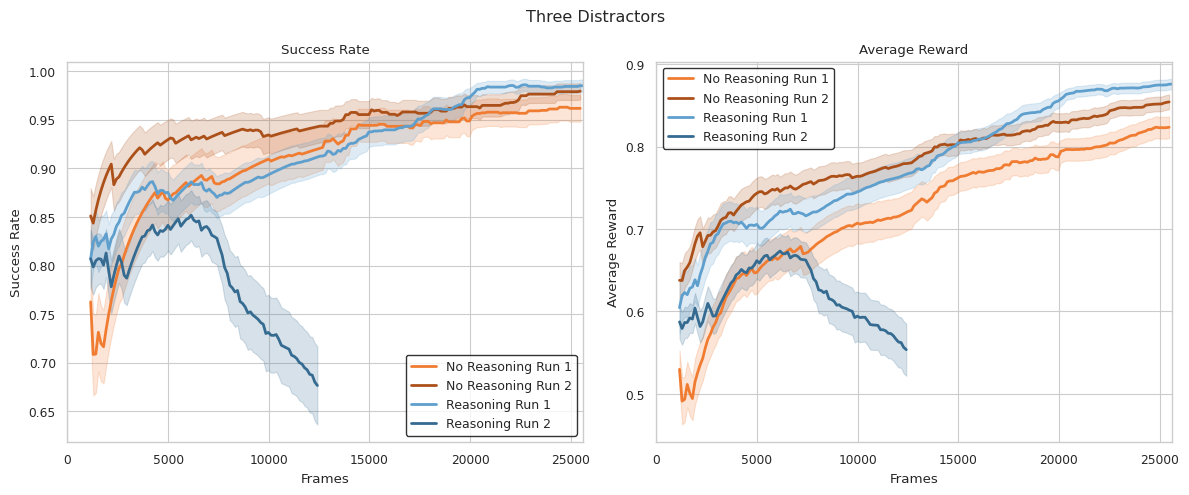

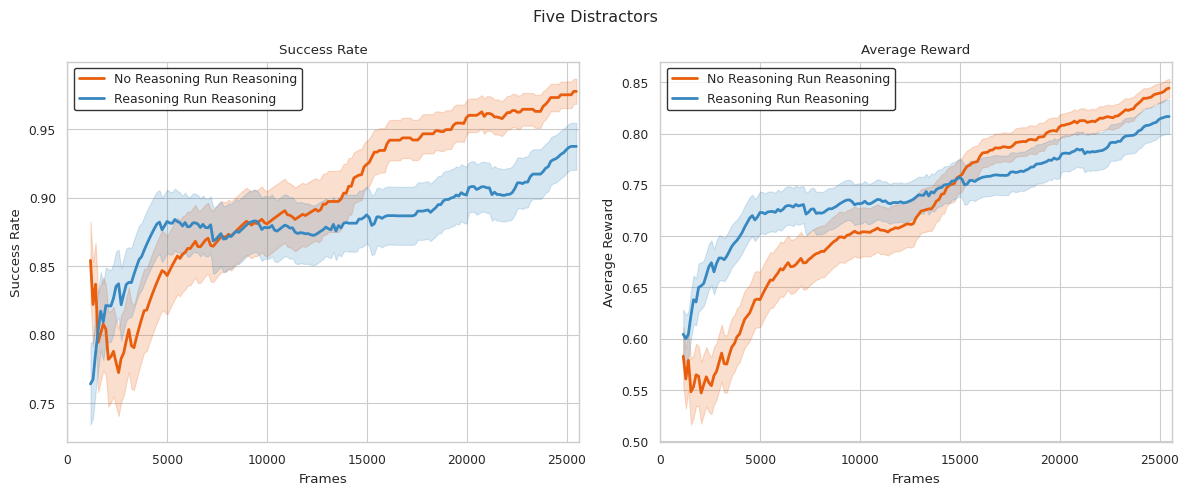

In [53]:
def get_data(run_id: str, rolling_window=100, cutoff=200):
    history = api.run(f"OE_2025/final_runs/{run_id}").history()
    xs = history['_step'][:cutoff] * 128
    
    # Get raw data for calculating std
    success_rates_raw = history['all_success_rate'][:cutoff]
    avg_rewards_raw = history['all_avg_reward'][:cutoff]
    
    # Calculate rolling means with min_periods=10
    success_rates_mean = success_rates_raw.rolling(rolling_window, min_periods=10).mean()
    avg_rewards_mean = avg_rewards_raw.rolling(rolling_window, min_periods=10).mean()
    
    # Calculate rolling standard deviations with min_periods=10
    success_rates_std = success_rates_raw.rolling(rolling_window, min_periods=10).std()
    avg_rewards_std = avg_rewards_raw.rolling(rolling_window, min_periods=10).std()
    
    return xs, success_rates_mean, avg_rewards_mean, success_rates_std, avg_rewards_std


def plot_comparison(distractor_level, reasoning_runs, no_reasoning_runs, rolling_window=100, std_scale=1/5, cutoff=200):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Define visual styles
    reasoning_linestyle = "-"  # solid line for reasoning
    no_reasoning_linestyle = "-"  # dashed line for no reasoning
    
    # Color palettes - one for reasoning runs, one for no-reasoning runs
    reasoning_colors = sns.color_palette("Blues_d", len(reasoning_runs))
    no_reasoning_colors = sns.color_palette("Oranges_d", len(no_reasoning_runs))
    
    # Plot No Reasoning runs
    for i, (name, run_id) in enumerate(no_reasoning_runs.items()):
        xs, success_rates, avg_rewards, success_std, reward_std = get_data(run_id, rolling_window, cutoff)
        success_std *= std_scale
        reward_std *= std_scale
        experiment_number = name.split()[-1]
        label = f"No Reasoning Run {experiment_number}"
        
        # Plot with error bands (using standard deviation)
        sns.lineplot(x=xs, y=success_rates, ax=axes[0], label=label, 
                     color=no_reasoning_colors[i], linestyle=no_reasoning_linestyle, linewidth=2)
        axes[0].fill_between(xs, success_rates-success_std, success_rates+success_std, 
                           color=no_reasoning_colors[i], alpha=0.2)
        
        sns.lineplot(x=xs, y=avg_rewards, ax=axes[1], label=label, 
                     color=no_reasoning_colors[i], linestyle=no_reasoning_linestyle, linewidth=2)
        axes[1].fill_between(xs, avg_rewards-reward_std, avg_rewards+reward_std, 
                           color=no_reasoning_colors[i], alpha=0.2)
    
    # Plot Reasoning runs
    for i, (name, run_id) in enumerate(reasoning_runs.items()):
        xs, success_rates, avg_rewards, success_std, reward_std = get_data(run_id, rolling_window, cutoff)
        success_std *= std_scale
        reward_std *= std_scale
        experiment_number = name.split()[-1]
        label = f"Reasoning Run {experiment_number}"
        
        # Plot with error bands (using standard deviation)
        sns.lineplot(x=xs, y=success_rates, ax=axes[0], label=label, 
                     color=reasoning_colors[i], linestyle=reasoning_linestyle, linewidth=2)
        axes[0].fill_between(xs, success_rates-success_std, success_rates+success_std, 
                           color=reasoning_colors[i], alpha=0.2)
        
        sns.lineplot(x=xs, y=avg_rewards, ax=axes[1], label=label, 
                     color=reasoning_colors[i], linestyle=reasoning_linestyle, linewidth=2)
        axes[1].fill_between(xs, avg_rewards-reward_std, avg_rewards+reward_std, 
                           color=reasoning_colors[i], alpha=0.2)
    
    # Titles and labels
    fig.suptitle(f"{distractor_level} Distractors")
    axes[0].set_title("Success Rate")
    axes[0].set_xlabel("Frames")
    axes[0].set_ylabel("Success Rate")
    axes[1].set_title("Average Reward")
    axes[1].set_xlabel("Frames")
    axes[1].set_ylabel("Average Reward")
    
    # Set x-axis limits
    axes[0].set_xlim(0, cutoff*128)
    axes[1].set_xlim(0, cutoff*128)
    
    # Improve legend appearance
    for ax in axes:
        legend = ax.legend(frameon=True, fontsize=9)
        legend.get_frame().set_edgecolor('black')
        legend.get_frame().set_linewidth(1.0)
    
    plt.tight_layout()
    return fig, axes


# Plot for Zero Distractors
plot_comparison("Zero", zero_distractor_reasoning_runs, zero_distractor_no_reasoning_runs, rolling_window=100, std_scale=1/7, cutoff=200)
plt.show()

# Plot for Three Distractors 
plot_comparison("Three", three_distractor_reasoning_runs, three_distractor_no_reasoning_runs, rolling_window=100, std_scale=1/7, cutoff=200)
plt.show()

# Plot for Five Distractors
plot_comparison("Five", five_distractor_reasoning_runs, five_distractor_no_reasoning_runs, rolling_window=100, std_scale=1/7, cutoff=200)
plt.show()

In [ ]:
# avg_reasoning_lengths_all = {}
# for name, run_id in reasoning_runs.items():
#     print(f"Processing: {name} ({run_id})")
#     reasoning_run = api.run(f"OE_2025/final_runs/{run_id}")
#     reasoning_run_history = reasoning_run.history()
#     steps = reasoning_run_history['_step']

#     avg_reasoning_lengths = []
#     for step in steps[:]:
#         print(f"Step {step}/{len(steps)}")
#         artifact = api.artifact(f"OE_2025/final_runs/run-{run_id}-game_log:v{step}")
#         artifact_dir = artifact.download()

#         table_path = os.path.join(artifact_dir, "game_log.table.json")
#         with open(table_path, 'r') as f:
#             table = json.load(f)

#         responses = [response for (query, response, reward) in table['data']]
#         reasoning_lengths = []
#         for response in responses:
#             if 'final answer' in response:
#                 reasoning = response.split('final answer')[0]
#                 reasoning_lengths.append(len(reasoning.split()))
#         avg_reasoning_length = sum(reasoning_lengths) / len(reasoning_lengths)
#         avg_reasoning_lengths.append(avg_reasoning_length)
    
#     avg_reasoning_lengths_all[name] = avg_reasoning_lengths

# # save avg reasoning lengths all to json
# with open("avg_reasoning_lengths_all.json", "w") as f:
#     json.dump(avg_reasoning_lengths_all, f)

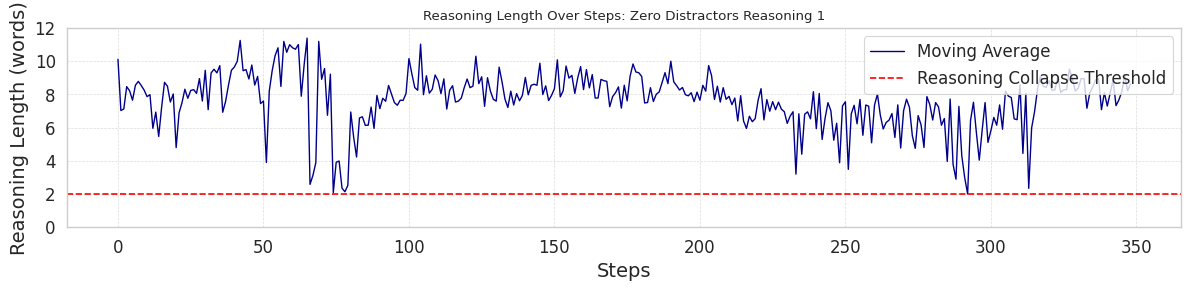

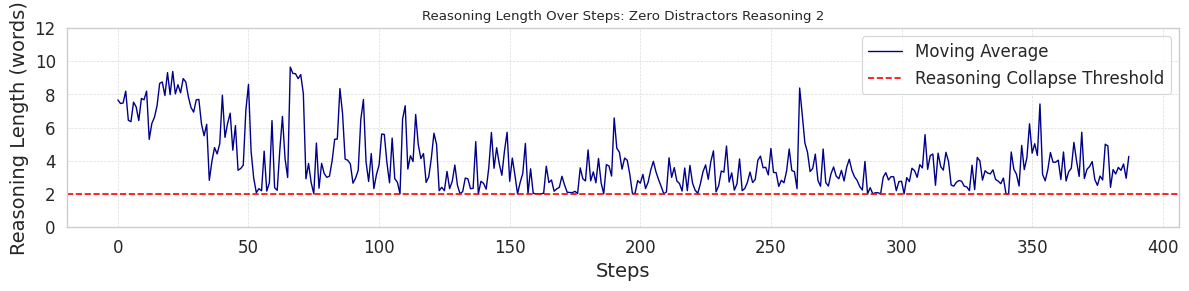

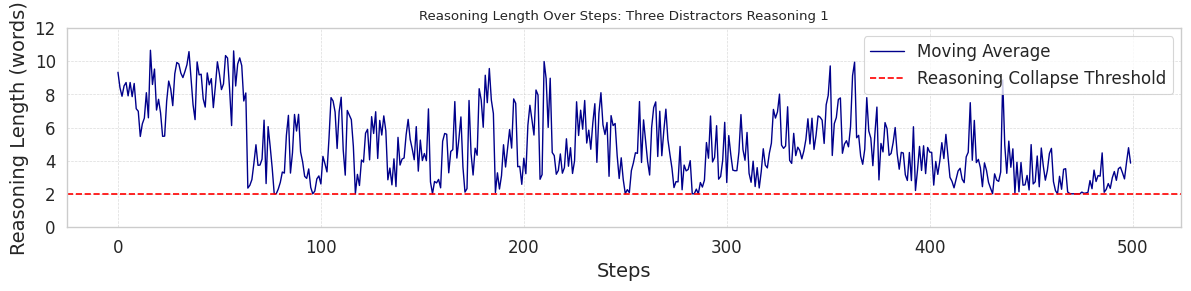

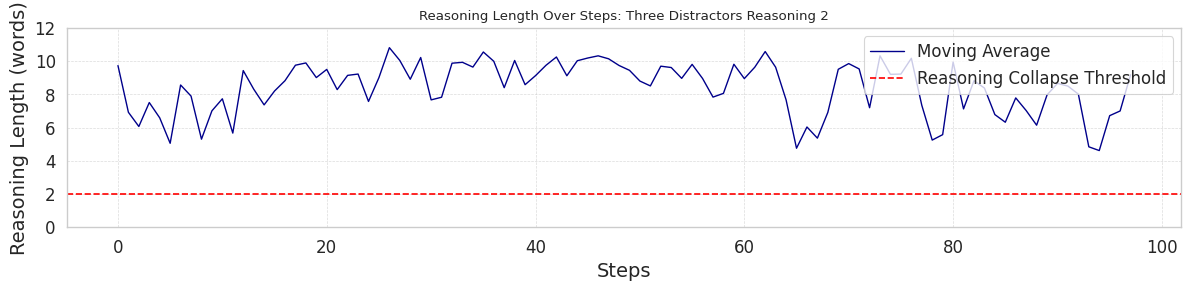

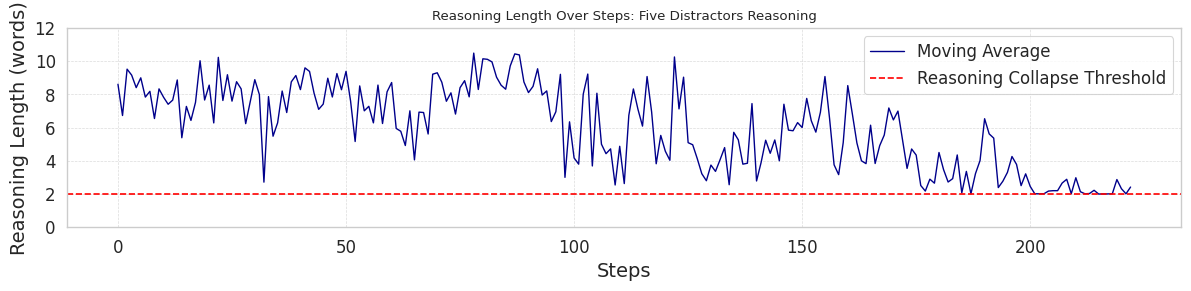

In [58]:
# Load avg reasoning lengths all from JSON
with open("avg_reasoning_lengths_all.json", "r") as f:
    avg_reasoning_lengths_all = json.load(f)

window_size = 1  # Adjust the window size as needed
for name, avg_reasoning_lengths in avg_reasoning_lengths_all.items():
    moving_avg = pd.Series(avg_reasoning_lengths).rolling(window=window_size).mean()
    plt.figure(figsize=(12, 3))
    sns.lineplot(x=range(len(moving_avg)), y=moving_avg, color="darkblue", linewidth=1, label="Moving Average")
    plt.axhline(y=2, color='red', linestyle='--', label='Reasoning Collapse Threshold')
    plt.title(f"Reasoning Length Over Steps: {name}")
    plt.xlabel("Steps", fontsize=14)
    plt.ylabel("Reasoning Length (words)", fontsize=14)
    plt.ylim(0, 12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend(fontsize=12, frameon=True, loc='upper right')
    plt.tight_layout()
    plt.show()